In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [10]:
#Set plotting style
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [13]:
# 1. Data Collection
def fetch_crypto_data(symbol='BTC', vs_currency='usd', days=365):
    """
    Fetch historical cryptocurrency data from CoinGecko API
    """
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Extract price data
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    
    return df

# Fetch Bitcoin data as an example
btc_data = fetch_crypto_data(symbol='bitcoin')
print(f"Data fetched: {len(btc_data)} days of Bitcoin price data")
btc_data.head()

Data fetched: 366 days of Bitcoin price data


,price
timestamp,
2024-04-06,67978.610234
2024-04-07,69000.649916
2024-04-08,69401.973609
2024-04-09,71624.184862
2024-04-10,69158.643812


In [17]:
# 2. Data Preprocessing
def preprocess_data(df, window_size=60, test_size=0.2, target_column='price'):
    """
    Preprocess data for LSTM model
    - Normalize data
    - Create sequences of window_size days for features
    - Split into training and testing sets
    """
    # Create a copy of the dataframe
    data = df.copy()
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[target_column]])
    
    # Create sequences
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Reshape X to fit LSTM input shape [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split data into train and test sets
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler

# Preprocess the Bitcoin data
window_size = 60  # Use 60 days of data to predict the next day
X_train, X_test, y_train, y_test, scaler = preprocess_data(btc_data, window_size=window_size)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (244, 60, 1)
Testing data shape: (62, 60, 1)


In [21]:
 #3. Build and Train LSTM Model
def build_lstm_model(input_shape):
    """
    Build an LSTM model for time series prediction
    """
    model = Sequential()
    
    # LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Build and train the model
input_shape = (X_train.shape[1], 1)
model = build_lstm_model(input_shape)

# Model summary
model.summary()

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - loss: 0.1444 - val_loss: 0.0989
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0356 - val_loss: 0.0126
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0240 - val_loss: 0.0525
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0185 - val_loss: 0.0054
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0178 - val_loss: 0.0440
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0178 - val_loss: 0.0042
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0164 - val_loss: 0.0262
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0130 - val_loss: 0.0048
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0109 - val_loss: 0.0231
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0121 - val_loss: 0.0073
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0118 - val_loss: 0.0214
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0124 - val_loss: 0.0

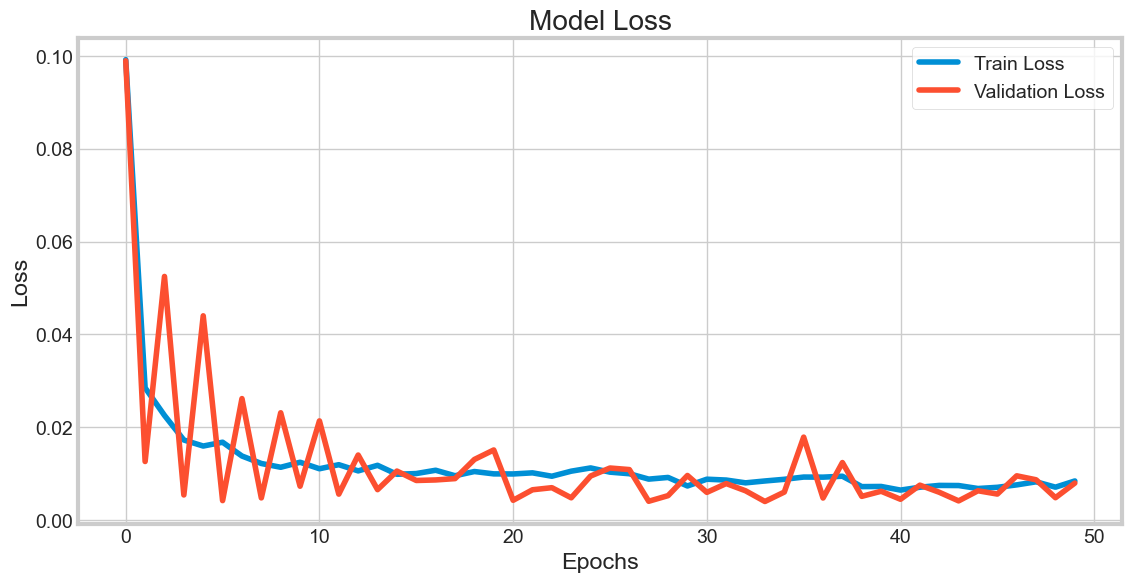

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 765ms/step
Mean Squared Error: 21843926.49
Mean Absolute Error: 3563.26
Root Mean Squared Error: 4673.75
R² Score: 0.4231


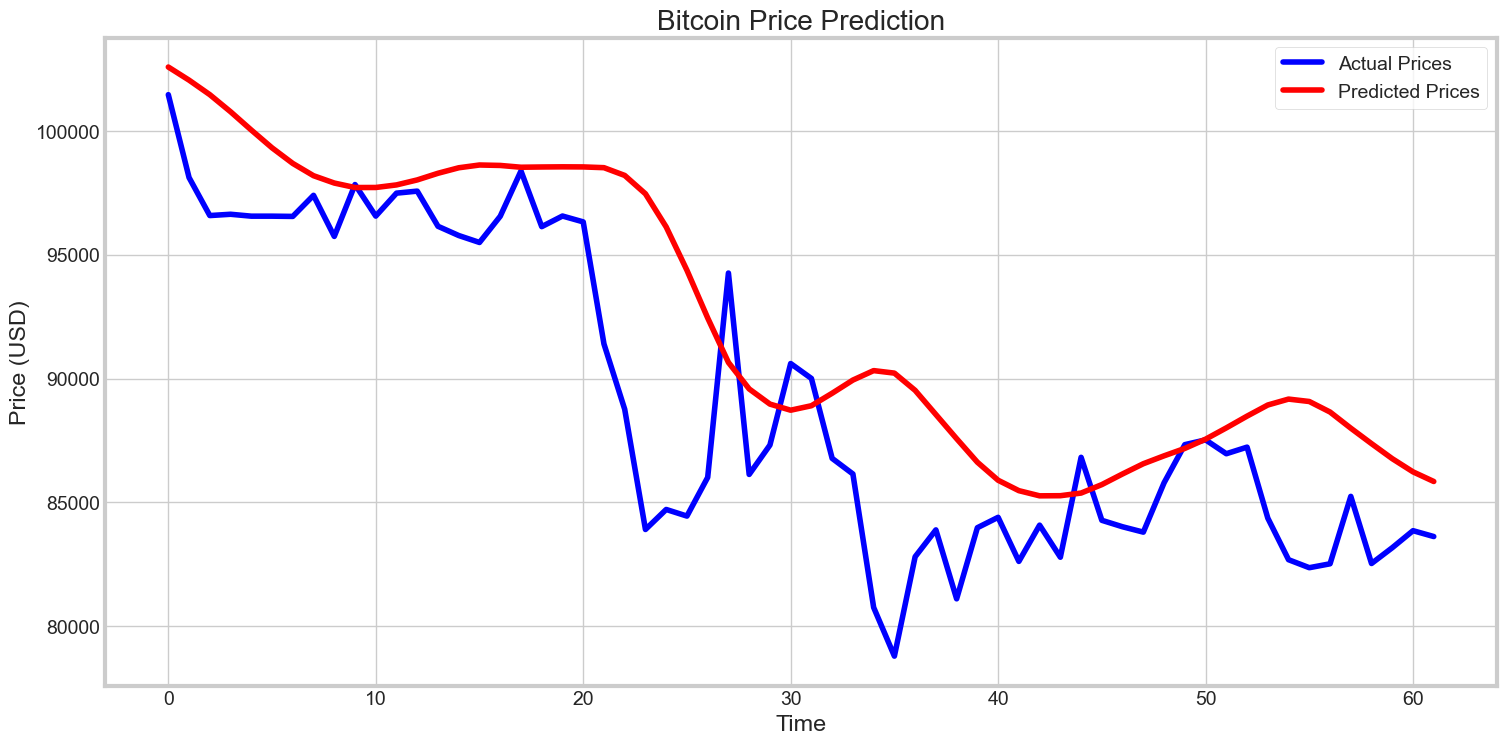

In [23]:
# 4. Evaluate the model and make predictions
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual prices
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(16, 8))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 

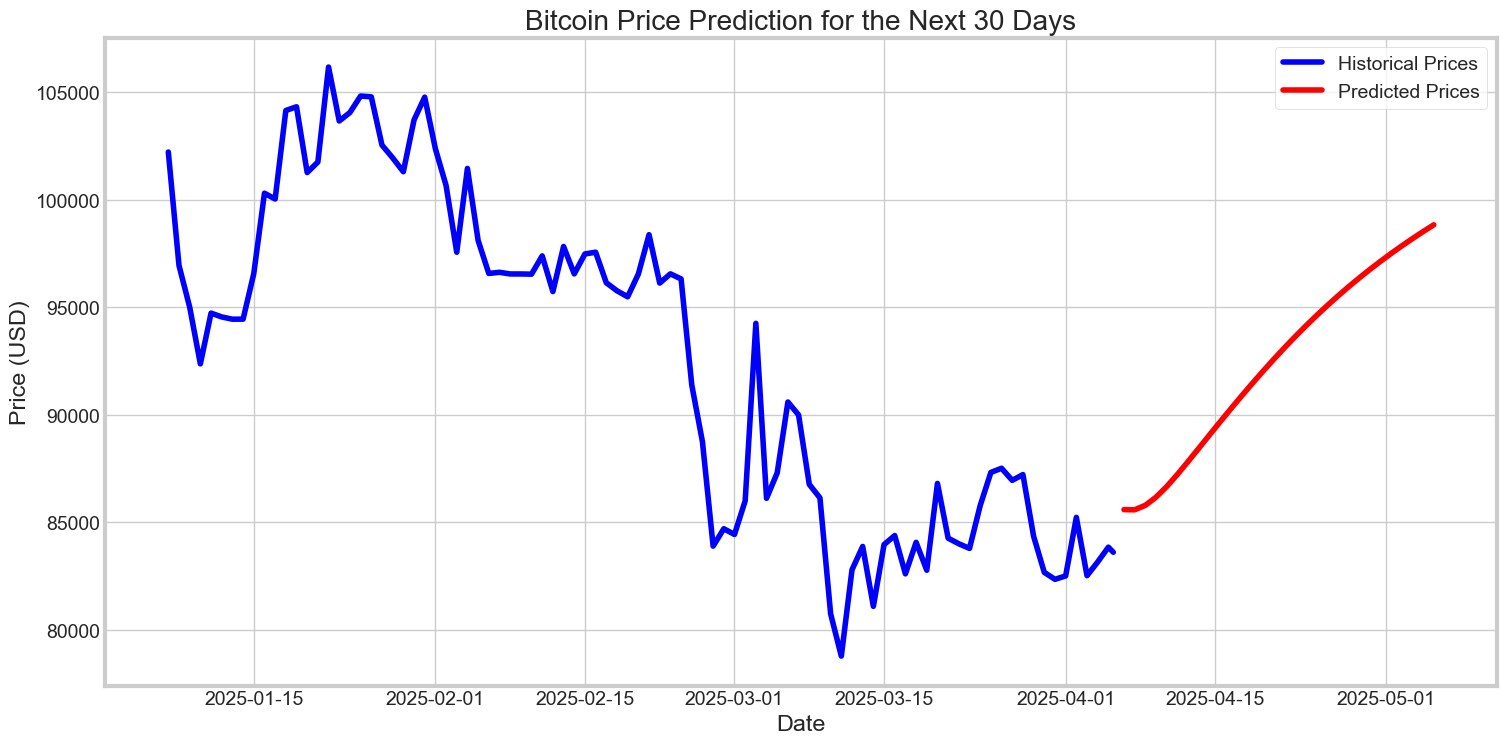

In [25]:
# 5. Make Future Predictions
def predict_future(model, data, scaler, days_to_predict=30, window_size=60):
    """
    Predict future prices based on the last window_size days
    """
    # Get the last window_size days of data
    last_window = data['price'].values[-window_size:]
    
    # Scale the data
    last_window_scaled = scaler.transform(last_window.reshape(-1, 1))
    
    # Create an empty list to store predictions
    future_predictions = []
    
    # Current batch for prediction
    current_batch = last_window_scaled.reshape(1, window_size, 1)
    
    # Predict each day one by one
    for _ in range(days_to_predict):
        # Make prediction for next day
        next_day_scaled = model.predict(current_batch)[0]
        
        # Add prediction to our list
        future_predictions.append(next_day_scaled[0])
        
        # Update current batch to include the new prediction
        current_batch = np.append(current_batch[:, 1:, :], 
                                 [[next_day_scaled]], 
                                 axis=1)
    
    # Convert scaled predictions back to actual values
    future_pred_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    
    # Create dates for the predictions
    last_date = data.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]
    
    # Create a dataframe with the predictions
    future_df = pd.DataFrame({
        'price': future_pred_actual.flatten()
    }, index=future_dates)
    
    return future_df

# Predict the next 30 days
future_days = 30
future_predictions = predict_future(model, btc_data, scaler, days_to_predict=future_days, window_size=window_size)

# Plot the predictions
plt.figure(figsize=(16, 8))
plt.plot(btc_data['price'][-90:], label='Historical Prices', color='blue')
plt.plot(future_predictions['price'], label='Predicted Prices', color='red')
plt.title(f'Bitcoin Price Prediction for the Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Model and scaler saved successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


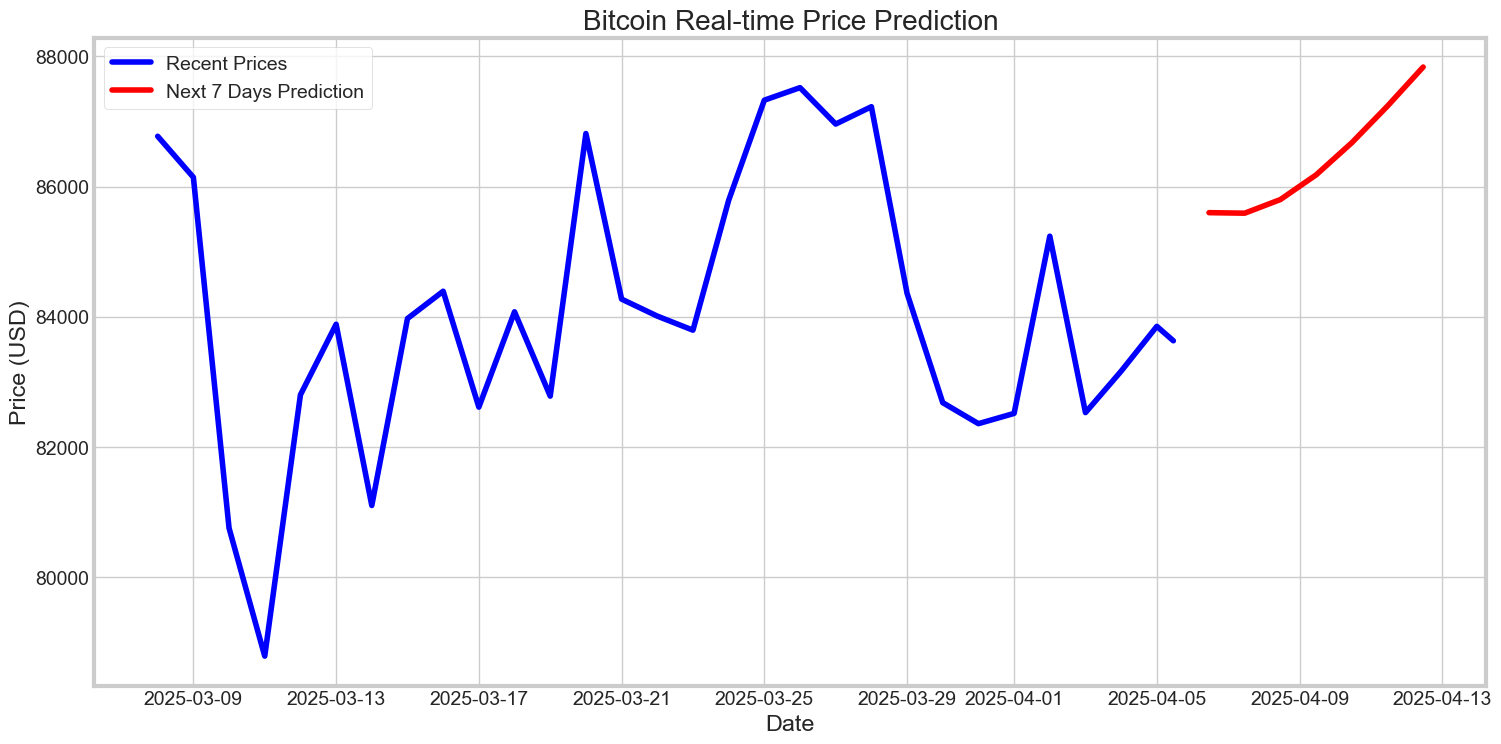

Real-time prediction completed successfully!


In [27]:
# 6. Save the Model for Later Use
model.save('crypto_price_prediction_model.h5')
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

# 7. Real-time Prediction Function
def predict_realtime(crypto_symbol='bitcoin', days_to_predict=7):
    """
    Fetch the latest data and make predictions
    """
    # Fetch the latest data
    latest_data = fetch_crypto_data(symbol=crypto_symbol)
    
    # Preprocess data
    X_train, X_test, y_train, y_test, new_scaler = preprocess_data(latest_data, window_size=window_size)
    
    # Load the saved model (comment this out if you're running the full notebook)
    # loaded_model = tf.keras.models.load_model('crypto_price_prediction_model.h5')
    # with open('scaler.pkl', 'rb') as f:
    #     new_scaler = pickle.load(f)
    
    # Make future predictions
    future_pred = predict_future(model, latest_data, new_scaler, days_to_predict=days_to_predict, window_size=window_size)
    
    return latest_data, future_pred

# Example usage of real-time prediction
latest_btc, future_btc = predict_realtime('bitcoin', days_to_predict=7)

# Plot the predictions
plt.figure(figsize=(16, 8))
plt.plot(latest_btc['price'][-30:], label='Recent Prices', color='blue')
plt.plot(future_btc['price'], label='Next 7 Days Prediction', color='red')
plt.title('Bitcoin Real-time Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print("Real-time prediction completed successfully!")